In [3]:
%cd ../..

/home/schilcherj/master/deepClustering/LMU_Master_Practical_SoSe24


/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from practical.DeepClustering.DipECT.dipect import Cluster_Tree, DipECT
from clustpy.deep._data_utils import get_dataloader
from clustpy.data.real_torchvision_data import load_mnist
from clustpy.deep.dipencoder import _Dip_Gradient, dip_test
from clustpy.deep.autoencoders import FeedforwardAutoencoder
import numpy as np
from sklearn.cluster import KMeans
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from clustpy.metrics import unsupervised_clustering_accuracy
import random
import umap
from sklearn.decomposition import PCA

/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


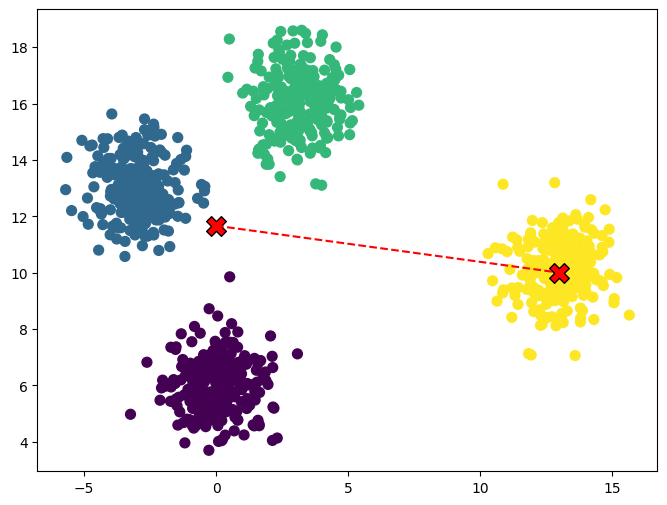

In [39]:
# Function to generate and plot blobs
def generate_and_plot_blobs(n_samples, centers, cluster_std):
    # Generate blobs
    centers = np.array(centers)
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=42)

    mean_sub_tree = np.mean(centers[:3], axis=0)[None, :]
    # Plot blobs
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
    plt.scatter(np.array(mean_sub_tree)[0, 0], np.array(mean_sub_tree)[0, 1], c='red', marker='X', s=200, edgecolor='k')
    plt.scatter(np.array(centers)[3, 0], np.array(centers)[3, 1], c='red', marker='X', s=200, edgecolor='k')
    
    
    centers = np.concatenate((mean_sub_tree, centers[3:4,:]), axis=0)
    plt.plot(centers[:, 0], centers[:, 1], 'r--')
    plt.show()

# Specify the centers for the blobs
centers = [[0, 6], [-3,13], [3, 16], [13, 10]]
# Number of samples per cluster
n_samples = 1000
# Standard deviation of the clusters
cluster_std = 1.0

# Generate and plot blobs with the specified centers
generate_and_plot_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std)


split node with #assignments:  533
True
0.99875


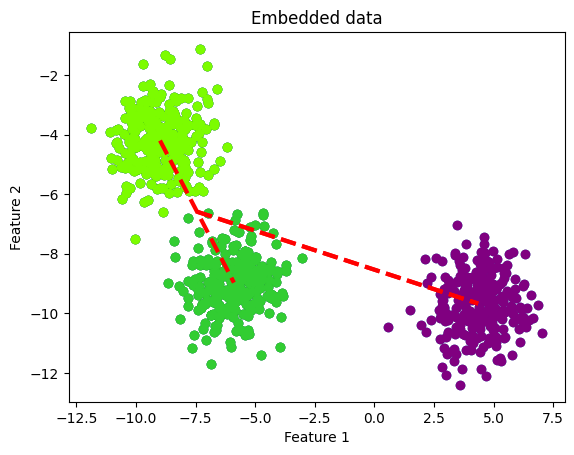

In [86]:
# Generate sample data
X, y = make_blobs(n_samples=800, centers=3, random_state=np.random.RandomState(21))

plt.scatter(X[:, 0], X[:, 1], marker='o')
plt.title('Embedded data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')



# X1, y1 = make_blobs(n_samples=50, centers=1)
# X2, y2 = make_blobs(n_samples=200, centers=1)
# X3, y3 = make_blobs(n_samples=100, centers=1)
# X4, y4 = make_blobs(n_samples=250, centers=1)

# Combine the datasets
# X = np.vstack((X1, X2, X3, X4))
# y = np.hstack((y1, y2 + 1, y3 + 2, y4 + 3))  

dataloader = get_dataloader(X, 50 )
encode = lambda x: x
autoencoder = type("Autoencoder", (), {"encode": encode})

tree = Cluster_Tree(dataloader, autoencoder, None, "cpu", max_leaf_nodes=10)

tree.assign_to_tree(torch.from_numpy(X))

center_1 = torch.mean(tree.root.lower_projection_child.assignments, dim=0).numpy()
center_2 = torch.mean(tree.root.higher_projection_child.assignments, dim=0).numpy()
centers = np.concatenate((np.expand_dims(center_1, 0), np.expand_dims(center_2, 0)), axis=0)
# plt.scatter(centers[:, 0], centers[:, 1], marker="X", c="red", s=200)
plt.plot(centers[:, 0], centers[:, 1], 'r--', linewidth=3)



# Create a scatter plot
plt.scatter(tree.root.lower_projection_child.assignments[:, 0], tree.root.lower_projection_child.assignments[:, 1], c="green", marker='o')
plt.scatter(tree.root.higher_projection_child.assignments[:, 0], tree.root.higher_projection_child.assignments[:, 1], c="purple", marker='o')
plt.plot(centers[:, 0], centers[:, 1], 'r--', linewidth=3)

# origin = [np.mean(X, axis=0)[0]], [np.mean(X, axis=0)[1]]  # Vector origin point
# plt.quiver(*origin, tree.root.projection_axis.data[0], tree.root.projection_axis.data[1], scale=5, color='red', label='Direction Vector')




tree.grow_tree(dataloader, autoencoder, None, 20, 1.0, 1, False)
tree.assign_to_tree(torch.from_numpy(X))

pred_labels = np.ones(len(X))*-1

if tree.root.lower_projection_child.is_leaf_node():
    plt.scatter(tree.root.higher_projection_child.lower_projection_child.assignments[:, 0],tree.root.higher_projection_child.lower_projection_child.assignments[:, 1], c="lime", marker='o')
    plt.scatter(tree.root.higher_projection_child.higher_projection_child.assignments[:, 0], tree.root.higher_projection_child.higher_projection_child.assignments[:, 1], c="springgreen", marker='o')

    # origin = [np.mean(tree.root.higher_projection_child.assignments.numpy(), axis=0)[0]], [np.mean(tree.root.higher_projection_child.assignments.numpy(), axis=0)[1]]  # Vector origin point
    # plt.quiver(*origin, tree.root.higher_projection_child.projection_axis.data[0], tree.root.higher_projection_child.projection_axis.data[1], scale=5, color='brown', label='Direction Vector')
    X_combined = torch.cat((tree.root.higher_projection_child.lower_projection_child.assignments, tree.root.higher_projection_child.higher_projection_child.assignments), dim=0)
    
    center_1 = torch.mean(tree.root.higher_projection_child.lower_projection_child.assignments, dim=0).numpy()
    center_2 = torch.mean(tree.root.higher_projection_child.higher_projection_child.assignments, dim=0).numpy()
    centers = np.concatenate((np.expand_dims(center_1, 0), np.expand_dims(center_2, 0)), axis=0)
    # plt.scatter(centers[:, 0], centers[:, 1], marker="X", c="red", s=200)
    plt.plot(centers[:, 0], centers[:, 1], 'r--', linewidth=3)

    X_combined_sorted, _ = torch.sort(X_combined, dim=0)
    X_sorted, _ = torch.sort(tree.root.higher_projection_child.assignments, dim=0)

    # Check if the sorted tensors are identical
    is_identical = torch.equal(X_sorted, X_combined_sorted)
    print(is_identical)
    pred_labels[tree.root.higher_projection_child.lower_projection_child.assignment_indices] = 0
    pred_labels[tree.root.higher_projection_child.higher_projection_child.assignment_indices] = 1
    pred_labels[tree.root.lower_projection_child.assignment_indices] = 2
else:
    plt.scatter(tree.root.lower_projection_child.lower_projection_child.assignments[:, 0],tree.root.lower_projection_child.lower_projection_child.assignments[:, 1], c="lawngreen", marker='o')
    plt.scatter(tree.root.lower_projection_child.higher_projection_child.assignments[:, 0], tree.root.lower_projection_child.higher_projection_child.assignments[:, 1], c="limegreen", marker='o')
    # origin = [np.mean(tree.root.lower_projection_child.assignments.numpy(), axis=0)[0]], [np.mean(tree.root.lower_projection_child.assignments.numpy(), axis=0)[1]]  # Vector origin point
    # plt.quiver(*origin, tree.root.lower_projection_child.projection_axis.data[0], tree.root.lower_projection_child.projection_axis.data[1], scale=5, color='brown', label='Direction Vector')

    center_1 = torch.mean(tree.root.lower_projection_child.lower_projection_child.assignments, dim=0).numpy()
    center_2 = torch.mean(tree.root.lower_projection_child.higher_projection_child.assignments, dim=0).numpy()
    centers = np.concatenate((np.expand_dims(center_1, 0), np.expand_dims(center_2, 0)), axis=0)
    # plt.scatter(centers[:, 0], centers[:, 1], marker="X", c="red", s=200)
    plt.plot(centers[:, 0], centers[:, 1], 'r--', linewidth=3)

    X_combined = torch.cat((tree.root.lower_projection_child.lower_projection_child.assignments, tree.root.lower_projection_child.higher_projection_child.assignments), dim=0)

    X_combined_sorted, _ = torch.sort(X_combined, dim=0)
    X_sorted, _ = torch.sort(tree.root.lower_projection_child.assignments, dim=0)

    # Check if the sorted tensors are identical
    is_identical = torch.equal(X_sorted, X_combined_sorted)
    print(is_identical)
    pred_labels[tree.root.lower_projection_child.lower_projection_child.assignment_indices] = 0
    pred_labels[tree.root.lower_projection_child.higher_projection_child.assignment_indices] = 1
    pred_labels[tree.root.higher_projection_child.assignment_indices] = 2

print(unsupervised_clustering_accuracy(y, pred_labels))

plt.show()

In [90]:
def get_inital_projection_axis(X_embedd):
        """
        Returns the inital projection axis for the data in the given trainloader. Furthermore, the size of the higher projection cluster and the lower projection cluster will be returned (e.g to initialise pruning indicator).
        """
        # init projection axis on full dataset
        kmeans = KMeans(n_clusters=2, n_init=10).fit(X_embedd)
        kmeans_centers = kmeans.cluster_centers_
        labels = kmeans.labels_
        axis = kmeans_centers[0] - kmeans_centers[1]
        
        return axis, kmeans_centers[0], kmeans_centers[1]
def predict_subclusters(data, axis):
        projections = data @ axis
        sorted_indices = projections.argsort()
        dip_value, modal_interval, modal_triangle = dip_test(projections[sorted_indices], is_data_sorted=True, just_dip=False)
        index_lower, index_upper = modal_interval
        index_tri1, index_tri2, index_tri3 = modal_triangle
        if projections[sorted_indices[index_tri2]] > projections[sorted_indices[index_upper]]:
                treshhold =  (projections[sorted_indices[index_tri2]] + projections[sorted_indices[index_upper]])/2
        else:
                treshhold =  (projections[sorted_indices[index_tri2]] + projections[sorted_indices[index_lower]])/2
        labels = np.zeros(len(data))
        labels[projections >= treshhold] = 1
        labels[sorted_indices[index_tri2]] = 2
        labels[sorted_indices[index_lower]] = 3
        labels[sorted_indices[index_upper]] = 3
        return labels


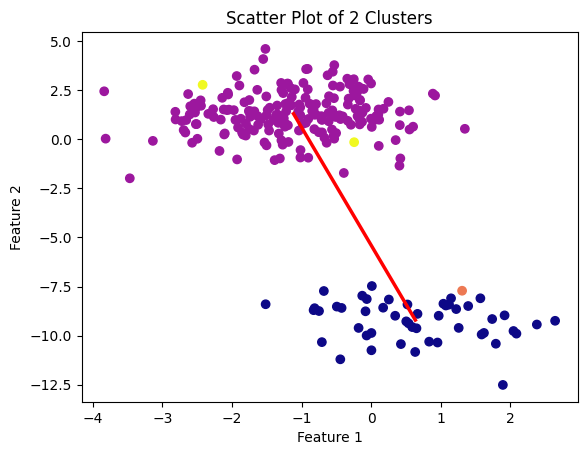

In [93]:
# Generate sample data
# X, y = make_blobs(n_samples=300, centers=2)
# Generate sample data with clusters of different sizes
X1, y1 = make_blobs(n_samples=50, centers=1,)
X2, y2 = make_blobs(n_samples=200, centers=1, )

# Combine the datasets
X = np.vstack((X1, X2))
y = np.hstack((y1, y2 + 1))  # Adjust labels for the second cluster

axis, c1, c2 = get_inital_projection_axis(X)

labels = predict_subclusters(X, axis)


# Create a scatter plot
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='plasma', marker='o')

# origin = [np.mean(X, axis=0)[0]], [np.mean(X, axis=0)[1]]  # Vector origin point
# plt.quiver(*origin, axis[0], axis[1], scale=5, color='red', label='Direction Vector')
plt.plot([c1[0], c2[0]], [c1[1], c2[1]], color='red',linewidth=2.5, label='Line between points')

# Add title and labels
plt.title('Scatter Plot of 2 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Show plot
plt.show()